# Data Pre-processing and Visualization

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import re
import os

## Loading Data

We will load the featurized superconducting data, and their chemical compositions. We will do a rough determination of whether a compound is cuprate or not based on whether it has both $Cu$ and $O$.

In [2]:
X = pd.read_csv('data/superconductors/train.csv')
composition = pd.read_csv('data/superconductors/unique_m.csv')[['Cu', 'O']]
is_cuprate = pd.DataFrame(data={'is_cuprate': composition['Cu'] * composition['O']}, dtype=float)
is_cuprate = is_cuprate > 0
cuprate_X = X[is_cuprate['is_cuprate']==True]
not_cuprate_X = X[is_cuprate['is_cuprate']==False]

## Clustering Data using KMeans
We cannot in general separate all compounds into classes of superconductors as defined in the literature. Therefore, we use KMeans clustering on the chemical composition to create artificial classes.

In [3]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X.drop(["critical_temp"],axis=1)))

n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaled_X)
clusters = kmeans.predict(scaled_X)
X["Cluster"] = clusters
scaled_X["Cluster"] = clusters
scaled_X = pd.concat([scaled_X, is_cuprate], axis=1, join='inner')

## Data Visualization Using PCA
We compare the clustering results to cuprates and non-cuprates to see how well the clustering follows human convention in this one specific way.

In [12]:
plotX = pd.DataFrame(np.array(scaled_X.sample(5000, random_state=10)))
plotX.columns = scaled_X.columns
pca_2d = PCA(n_components=2)
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster","is_cuprate"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
plotX = pd.concat([plotX, PCs_2d], axis=1, join='inner')
clusters = [plotX[plotX["Cluster"] == i] for i in range(n_clusters)]

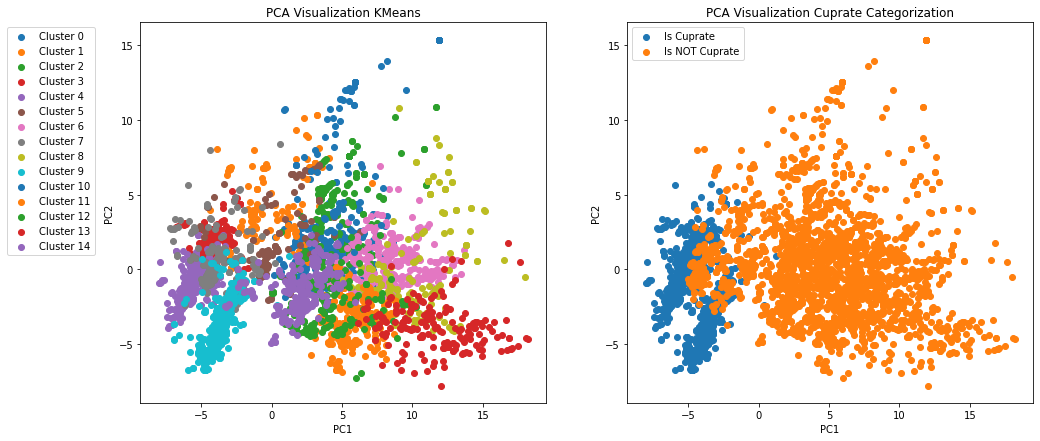

In [20]:
fig = plt.figure(figsize=(16, 7))
ax =fig.add_subplot(1,2,1)
ay =fig.add_subplot(1,2,2)

for i in range(n_clusters):

    ax.scatter(clusters[i]["PC1_2d"], clusters[i]["PC2_2d"], label = "Cluster {}".format(i))
    
for cuprate_or_not in ['Is Cuprate', 'Is NOT Cuprate']:
    
    x = plotX[plotX['is_cuprate'] == (cuprate_or_not=='Is Cuprate')]["PC1_2d"],
    y = plotX[plotX['is_cuprate'] == (cuprate_or_not=='Is Cuprate')]["PC2_2d"],
    ay.scatter(x, y, label = cuprate_or_not)

ax.set_title("PCA Visualization KMeans")
ax.legend(bbox_to_anchor=(-0.1, 1))
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ay.set_ylabel('PC2')
ay.set_xlabel('PC1')
ay.set_title("PCA Visualization Cuprate Categorization")
ay.legend()

We see that clusters 3, 4 and 9  obtained using KMeans clustering are roughly cuprates. However, this is rather confusing. We therefore need to use a better visualization tool.

## Data Visualization Using t-SNE
Results obtained via PCA is rather confusing. t-SNE is a more sophisticated method. We illustrate that here.

In [21]:
plotX = pd.DataFrame(np.array(scaled_X.sample(5000)))
plotX.columns = scaled_X.columns
#Set our perplexity
perplexity = 50
#T-SNE with two dimensions
tsne_2d = TSNE(n_components=2, perplexity=perplexity)
#This DataFrame contains two dimensions, built by T-SNE
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plotX.drop(["Cluster","is_cuprate"], axis=1)))
TCs_2d.columns = ["TC1_2d","TC2_2d"]
plotX = pd.concat([plotX, TCs_2d], axis=1, join='inner')
clusters = [plotX[plotX["Cluster"] == i] for i in range(n_clusters)]

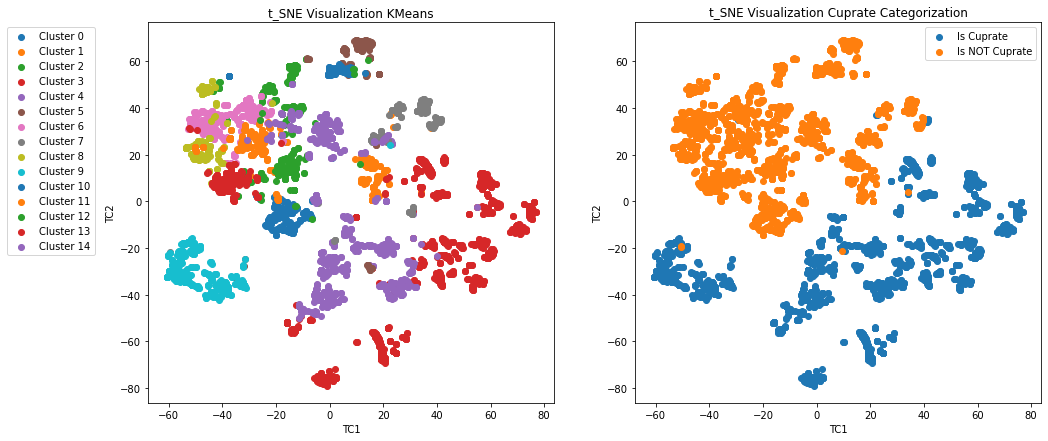

In [24]:
fig = plt.figure(figsize=(16, 7))
ax =fig.add_subplot(1,2,1)
ay =fig.add_subplot(1,2,2)

for i in range(n_clusters):

    ax.scatter(clusters[i]["TC1_2d"], clusters[i]["TC2_2d"], label = "Cluster {}".format(i))
    
for cuprate_or_not in ['Is Cuprate', 'Is NOT Cuprate']:
    
    x = plotX[plotX['is_cuprate'] == (cuprate_or_not=='Is Cuprate')]["TC1_2d"],
    y = plotX[plotX['is_cuprate'] == (cuprate_or_not=='Is Cuprate')]["TC2_2d"],
    ay.scatter(x, y, label = cuprate_or_not)

ax.set_title("t_SNE Visualization KMeans")
ax.legend(bbox_to_anchor=(-0.12, 1))
ax.set_ylabel('TC2')
ax.set_xlabel('TC1')
ay.set_ylabel('TC2')
ay.set_xlabel('TC1')
ay.set_title("t_SNE Visualization Cuprate Categorization")
ay.legend()

With t-SNE, it is clear that cuprates correspond to clusters 3, 4 and 9 and there are few mis-categorizations.

## Redo Clustering on Cuprates
Since we will hold cuprates from training, we need to redo clustering on non-cuprate families.

In [26]:
scaler = StandardScaler()


scaled_cuprate_X = pd.DataFrame(scaler.fit_transform(cuprate_X.drop(["critical_temp"],axis=1)))
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaled_cuprate_X)
cuprate_clusters = kmeans.predict(scaled_cuprate_X)
cuprate_X["Cluster"] = cuprate_clusters
scaled_cuprate_X["Cluster"] = cuprate_clusters


scaled_X = pd.DataFrame(scaler.fit_transform(not_cuprate_X.drop(["critical_temp"],axis=1)))
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaled_X)
clusters = kmeans.predict(scaled_X)
not_cuprate_X["Cluster"] = clusters
scaled_X["Cluster"] = clusters

<ipython-input-26-14954b69419c>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-14954b69419c>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
cuprate_plotX = pd.DataFrame(np.array(scaled_cuprate_X.sample(5000)))
cuprate_plotX.columns = scaled_cuprate_X.columns
#Set our perplexity
perplexity = 50
#T-SNE with two dimensions
tsne_2d = TSNE(n_components=2, perplexity=perplexity)
#This DataFrame contains two dimensions, built by T-SNE
cuprate_TCs_2d = pd.DataFrame(tsne_2d.fit_transform(cuprate_plotX.drop(["Cluster"], axis=1)))
cuprate_TCs_2d.columns = ["TC1_2d","TC2_2d"]
cuprate_plotX = pd.concat([cuprate_plotX, cuprate_TCs_2d], axis=1, join='inner')
cuprate_clusters = [cuprate_plotX[cuprate_plotX["Cluster"] == i] for i in range(n_clusters)]



plotX = pd.DataFrame(np.array(scaled_X.sample(5000)))
plotX.columns = scaled_X.columns
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))
TCs_2d.columns = ["TC1_2d","TC2_2d"]
plotX = pd.concat([plotX, TCs_2d], axis=1, join='inner')
clusters = [plotX[plotX["Cluster"] == i] for i in range(n_clusters)]

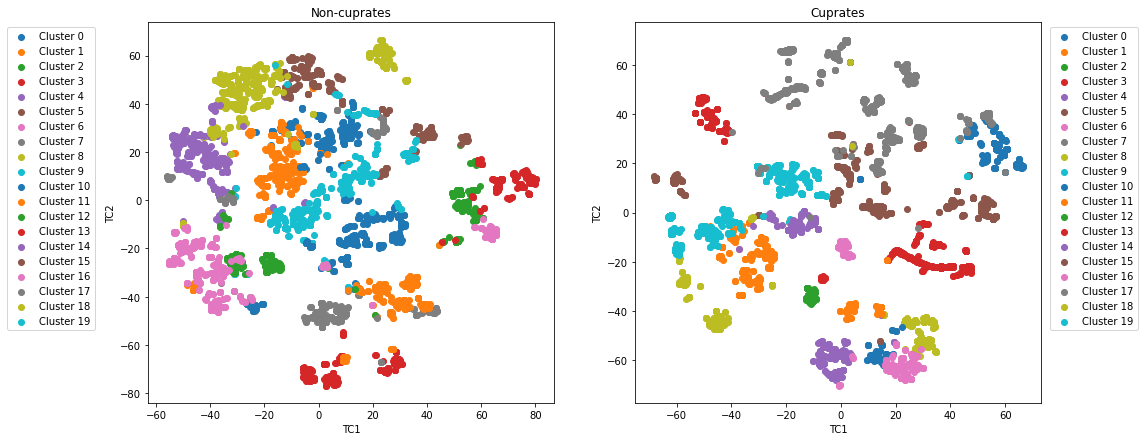

In [31]:
fig = plt.figure(figsize=(16, 7))
ax =fig.add_subplot(1,2,1)
ay =fig.add_subplot(1,2,2)

for i in range(n_clusters):

    ax.scatter(clusters[i]["TC1_2d"], clusters[i]["TC2_2d"], label = "Cluster {}".format(i))
    
for i in range(n_clusters):
    
    ay.scatter(cuprate_clusters[i]["TC1_2d"], cuprate_clusters[i]["TC2_2d"], label = "Cluster {}".format(i))

ax.set_title("Non-cuprates")
ax.legend(bbox_to_anchor=(-0.12, 1))
ax.set_ylabel('TC2')
ax.set_xlabel('TC1')
ay.set_ylabel('TC2')
ay.set_xlabel('TC1')
ay.set_title("Cuprates")
ay.legend(bbox_to_anchor=(1.25, 1))

## Saving Clustering Results

In [32]:
not_cuprate_X.to_csv('data/superconductors/not_cuprate.csv')
cuprate_X.to_csv('data/superconductors/cuprate.csv')

# Data Loading

Utility functions for data loading and few-shot episode preparation can be found in `Prototypical_Network\utils.py` or `MAML\utils.py`. In `load_data`, training or testing data is loaded and rescaled. In `extract_episode`, samples from `num_way` clusters (randomly chosen clusters and randomly chosen samples) are drawn, and the data and configuration parameters are returned in a dictionary.

# Prototypical Network

For the prototypical network, the embeddings are generated using a full connected neural network. Since the network was originally for image classification, it is a convolutional neural network. We change it into a fully connected network by changing line 70 through 89 of `Prototypical_Network\fewshot.py` in `load_protonet`.

For temperature prediction, we use the weighted sum in line 60 of `Prototypical_Network\few_shot.py`:

```python
dists = euclidean_dist(zq, zs)
p_y = F.softmax(-dists, dim=1)
y_hat = torch.tensordot(p_y, y_support, dims=([1],[0]))
```
Here, `zq` and `zs` are embeddings for query and support samples. Softmax normalizes the weights, and tensordot computes the weighted sum.

# Model Agnostic Meta Learning

The MAML network used is also a fully connected neural network. We do this by changing the model configuration `net_config` variable in the main function of `MAML\train_eval`. This is reflected in line 30.

Further, we need to change the loss from cross entropy loss (for classification in the original implementation) to MAE. This is reflected in  line 90, 98, 105, 112, 120, 160, 179, 187 or `MAML\maml.py`.

# Training Prototypical Network

We will run the training script and output the performance to './Prototypical_Network/history.out'

In [33]:
os.chdir('./Prototypical_Network')
!python -u train_eval.py --train.epochs 30 > history.out
os.chdir('../')


100%|##########| 100/100 [00:02<00:00, 40.18it/s]

100%|##########| 100/100 [00:02<00:00, 39.68it/s]

100%|##########| 100/100 [00:02<00:00, 40.20it/s]

100%|##########| 100/100 [00:01<00:00, 64.67it/s]

100%|##########| 100/100 [00:01<00:00, 63.36it/s]

100%|##########| 100/100 [00:01<00:00, 63.26it/s]

100%|##########| 100/100 [00:01<00:00, 63.59it/s]

100%|##########| 100/100 [00:01<00:00, 62.19it/s]

100%|##########| 100/100 [00:01<00:00, 62.87it/s]

100%|##########| 100/100 [00:01<00:00, 62.72it/s]

100%|##########| 100/100 [00:01<00:00, 63.18it/s]

100%|##########| 100/100 [00:01<00:00, 63.98it/s]

100%|##########| 100/100 [00:01<00:00, 62.40it/s]

100%|##########| 100/100 [00:01<00:00, 64.64it/s]

100%|##########| 100/100 [00:01<00:00, 63.90it/s]

100%|##########| 100/100 [00:01<00:00, 63.67it/s]

100%|##########| 100/100 [00:01<00:00, 63.44it/s]

100%|##########| 100/100 [00:01<00:00, 63.57it/s]

100%|##########| 100/100 [00:01<00:00, 63.64it/s]

100%|##########| 100/100 [00:0

Reading Performance From File

In [2]:
accuracies = []
read = False
acc_pattern = re.compile(r'Validation')
file = open('./Prototypical_Network/history.out', 'r')
lines = file.readlines()
for line in lines:
    if read:
        acc = float(line[-8:])
        accuracies.append(acc)
        read = False
    else:
        res = re.search(acc_pattern, line)
        if res != None:
            read = True

Plotting Performance

The best prototypical network gives an average temperature error 21.5106.


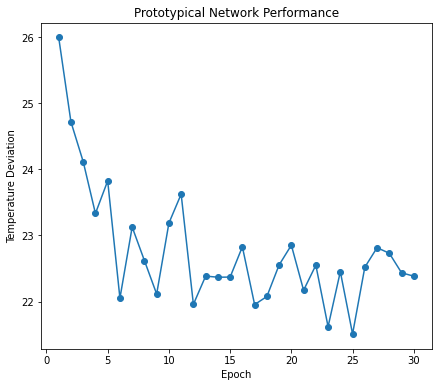

In [4]:
x = np.linspace(1, len(accuracies), num=len(accuracies))
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(x, np.array(accuracies), 'o-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Temperature Deviation')
ax.set_title('Prototypical Network Performance')

print('The best prototypical network gives an average temperature error {}.'.format(min(accuracies)))

# Training MAML

We will run the training script and output the performance to './MAML/history.out'

In [39]:
os.chdir('./MAML')
!python -u train_eval.py --update_step_test 50 > history.out
os.chdir('../')

Reading Performance From File

In [3]:
accuracies = []
test_losses = []
min_test_loss = 1000
episode_losses = np.zeros(0)
read = False
acc_pattern = re.compile(r'Test loss')
num_pattern = re.compile(r'\d*\.\d*')
end_pattern = re.compile(r'\]')
file = open('./MAML/history.out', 'r')
lines = file.readlines()
for line in lines:
    res = re.search(acc_pattern, line)
    if res != None:
        read = True
    if read:
        res = num_pattern.findall(line)
        res = np.array([float(loss) for loss in res])
        episode_losses = np.concatenate((episode_losses, res))
        res = re.search(end_pattern, line)
        if res != None:
            read = False
            episode_loss = episode_losses.min()
            test_losses.append(episode_loss)
            if episode_loss < min_test_loss:
                min_test_loss = episode_losses.min()
                min_episode_losses = episode_losses
            episode_losses =  np.zeros(0)

Plotting Performance

The best MAML gives an average temperature error 18.9.


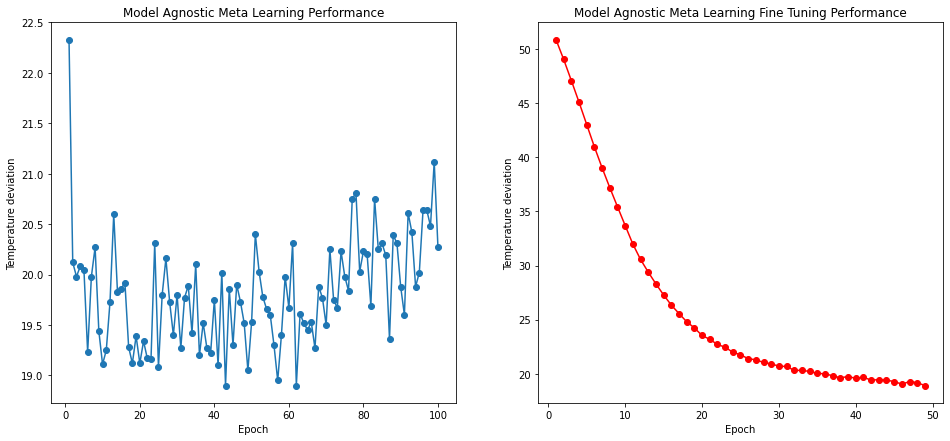

In [4]:
x1 = np.linspace(1, len(test_losses), num=len(test_losses))
x2 = np.linspace(1, len(min_episode_losses), num=len(min_episode_losses))

fig = plt.figure(figsize=(16, 7))
ax =fig.add_subplot(1,2,1)
ay =fig.add_subplot(1,2,2)

ax.plot(x1, np.array(test_losses), 'o-')
ay.plot(x2, np.array(min_episode_losses), 'ro-')

ax.set_title("Model Agnostic Meta Learning Performance")
ax.set_ylabel('Temperature deviation')
ax.set_xlabel('Epoch')
ay.set_ylabel('Temperature deviation')
ay.set_xlabel('Epoch')
ay.set_title("Model Agnostic Meta Learning Fine Tuning Performance")

print('The best MAML gives an average temperature error {}.'.format(min(min_episode_losses)))

# Comparing Performance with Classical Methods

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge


import warnings; warnings.filterwarnings('ignore')

In [41]:
cuprate_X = pd.read_csv('./data/superconductors/cuprate.csv')
train_data, test_data = train_test_split(cuprate_X, train_size =  50)

In [42]:
### remove Tc column from training data
train_Tc = train_data['critical_temp'].copy()
train_data.drop('critical_temp', axis = 1, inplace = True)

test_Tc = test_data['critical_temp'].copy()
test_data.drop('critical_temp', axis = 1, inplace = True)

## Testing on Random Forest Model with No Feature Selection

In [43]:
noFS_RFmodel = RandomForestRegressor()

In [44]:
noFS_RFmodel.fit(train_data, train_Tc)

noFS_RFmodel_predictions = noFS_RFmodel.predict(test_data)

print(mean_absolute_error(y_true = test_Tc, y_pred = noFS_RFmodel_predictions))
print(mean_squared_error(y_true = test_Tc, y_pred = noFS_RFmodel_predictions, squared=False))

18.72161677160847
23.25338116752999


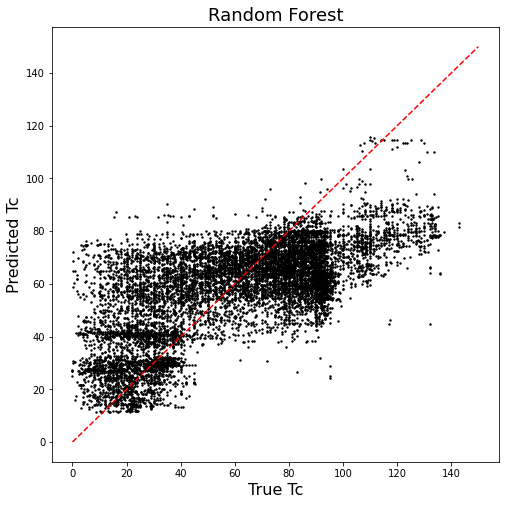

In [45]:
plt.figure(figsize = (8,8))
plt.scatter(test_Tc,noFS_RFmodel_predictions, s = 2, color = 'black')

plt.title('Random Forest', fontsize = 18)
plt.xlabel('True Tc', fontsize = 16)
plt.ylabel('Predicted Tc', fontsize = 16)


xtest = np.linspace(0, 150,100)
plt.plot(xtest, xtest, color = 'red', ls= '--')

# KNN Regression

In [46]:
knn = Pipeline([
    ('knn', KNeighborsRegressor(n_neighbors= 5, metric='jaccard', n_jobs= 2))  
])

In [47]:
knn.fit(train_data, train_Tc)
knn_model_predictions = knn.predict(test_data)
print(mean_absolute_error(y_true = test_Tc, y_pred = knn_model_predictions))
print(mean_squared_error(y_true = test_Tc, y_pred = knn_model_predictions, squared=False))

27.64080948292311
32.29484778668953


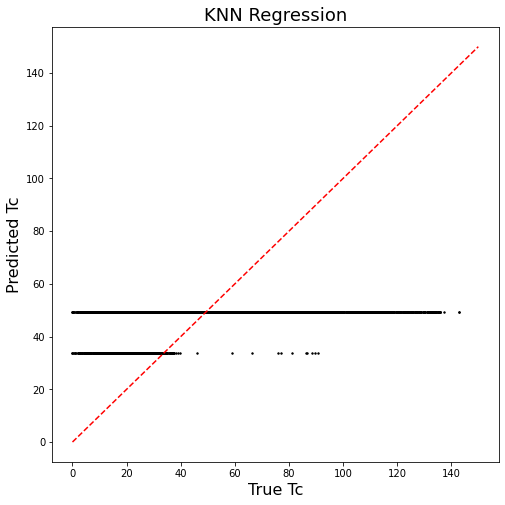

In [48]:
plt.figure(figsize = (8,8))
plt.scatter(test_Tc, knn_model_predictions, s = 2, color = 'black')

plt.title('KNN Regression', fontsize = 18)
plt.xlabel('True Tc', fontsize = 16)
plt.ylabel('Predicted Tc', fontsize = 16)

xtest = np.linspace(0, 150,100)
plt.plot(xtest, xtest, color = 'red', ls= '--')

# Simple Kernel Ridge Regression with RBF Kernel 

In [49]:
krr_model = Pipeline([
    ('scale', StandardScaler()),
    ('krr', KernelRidge(kernel='rbf'))
])

In [50]:
gs = GridSearchCV(krr_model,
    {'krr__gamma': np.logspace(-8, 0, 16), 'krr__alpha': np.logspace(-8, 0, 16)}, # two hyper-parameters
    cv=10,
    scoring='neg_mean_squared_error'  
)

In [51]:
gs.fit(train_data, train_Tc)
krr_model_pred = gs.best_estimator_.predict(test_data)
print(mean_absolute_error(y_true = test_Tc, y_pred = krr_model_pred))
print(mean_squared_error(y_true = test_Tc, y_pred = krr_model_pred, squared=False))

19.579011262636897
24.14791350122067


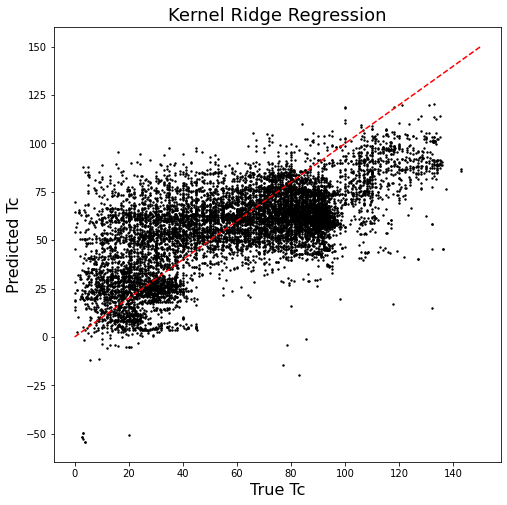

In [52]:
plt.figure(figsize = (8,8))
plt.scatter( test_Tc, krr_model_pred, s = 2, color = 'black')

plt.title('Kernel Ridge Regression', fontsize = 18)
plt.xlabel('True Tc', fontsize = 16)
plt.ylabel('Predicted Tc', fontsize = 16)

xtest = np.linspace(0, 150,100)
plt.plot(xtest, xtest, color = 'red', ls= '--')

# XGBoost (Close Approximation to Source Paper)

The library is not in the applied-ai environment.

In [53]:
from xgboost import XGBRegressor

In [54]:
xgb_model = XGBRegressor(max_depth = 16,tree_size = 374, colsample_bytree = 0.5,
                         learning_rate = 0.02, min_child_weight = 1)

xgb_model.fit(train_data, train_Tc)
xgb_pred = xgb_model.predict(test_data)
print(mean_absolute_error(y_true = test_Tc, y_pred = xgb_pred ))
print(mean_squared_error(y_true = test_Tc, y_pred = xgb_pred, squared=False))

[20:33:22] WARNING: ../src/learner.cc:576: 
Parameters: { "tree_size" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


22.80497626864894
29.247844745020622


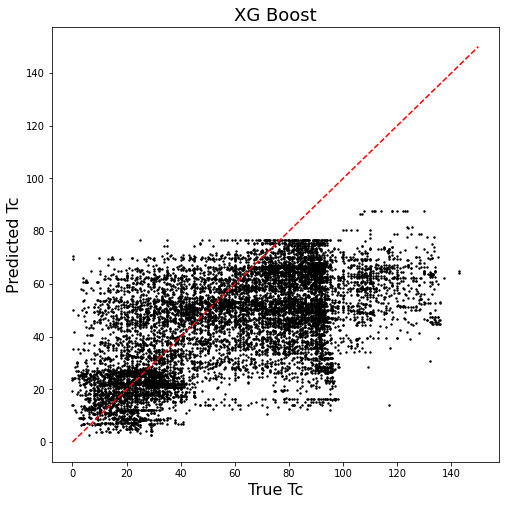

In [55]:
plt.figure(figsize = (8,8))
plt.scatter( test_Tc, xgb_pred, s = 2, color = 'black')

plt.title('XG Boost', fontsize = 18)
plt.xlabel('True Tc', fontsize = 16)
plt.ylabel('Predicted Tc', fontsize = 16)

xtest = np.linspace(0, 150,100)
plt.plot(xtest, xtest, color = 'red', ls= '--')